In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np

import sys
import os

sys.path.append(os.environ['REPO_DIR'] + '/utilities')
from utilities2015 import *

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd

from matplotlib.path import Path
from itertools import product

from collections import defaultdict

import time

In [2]:
volume_dir = create_if_not_exists('/oasis/projects/nsf/csd395/yuncong/CSHL_volumes/')

In [3]:
volume_landmark_names_unsided = ['12N', '5N', '6N', '7N', '7n', 'AP', 'Amb', 'LC',
                                 'LRt', 'Pn', 'R', 'RtTg', 'Tz', 'VLL', 'sp5']
linear_landmark_names_unsided = ['outerContour']

labels_unsided = volume_landmark_names_unsided + linear_landmark_names_unsided
labels_unsided_indices = dict((j, i+1) for i, j in enumerate(labels_unsided))  # BackG always 0

labelMap_unsidedToSided = {'12N': ['12N'],
                            '5N': ['5N_L', '5N_R'],
                            '6N': ['6N_L', '6N_R'],
                            '7N': ['7N_L', '7N_R'],
                            '7n': ['7n_L', '7n_R'],
                            'AP': ['AP'],
                            'Amb': ['Amb_L', 'Amb_R'],
                            'LC': ['LC_L', 'LC_R'],
                            'LRt': ['LRt_L', 'LRt_R'],
                            'Pn': ['Pn_L', 'Pn_R'],
                            'R': ['R_L', 'R_R'],
                            'RtTg': ['RtTg'],
                            'Tz': ['Tz_L', 'Tz_R'],
                            'VLL': ['VLL_L', 'VLL_R'],
                            'sp5': ['sp5'],
                           'outerContour': ['outerContour']}

labelMap_sidedToUnsided = {n: nu for nu, ns in labelMap_unsidedToSided.iteritems() for n in ns}

from itertools import chain
labels_sided = list(chain(*(labelMap_unsidedToSided[name_u] for name_u in labels_unsided)))
labels_sided_indices = dict((j, i+1) for i, j in enumerate(labels_sided)) # BackG always 0

In [4]:
downsample_factor = 16

section_thickness = 20 # in um
xy_pixel_distance_lossless = 0.46
xy_pixel_distance_tb = xy_pixel_distance_lossless * 32 # in um, thumbnail
# factor = section_thickness/xy_pixel_distance_lossless

xy_pixel_distance_downsampled = xy_pixel_distance_lossless * downsample_factor
z_xy_ratio_downsampled = section_thickness / xy_pixel_distance_downsampled

In [5]:
username = 'yuncong'

In [6]:
stack = 'MD594'
    
section_bs_begin, section_bs_end = section_range_lookup[stack]
detect_sec_begin, detect_sec_end = detect_bbox_range_lookup[stack]
mid_section = (section_bs_begin + section_bs_end)/2

print section_bs_begin, section_bs_end
print detect_sec_begin, detect_sec_end
print 'middle section', mid_section

93 364
143 305
middle section 228


In [7]:
from annotation_utilities import *
label_polygons = load_label_polygons_if_exists(stack, username, force=True)

username yuncong does not have any annotations for current section 93 
username yuncong does not have any annotations for current section 94 
username yuncong does not have any annotations for current section 95 
username yuncong does not have any annotations for current section 97 
username yuncong does not have any annotations for current section 99 
username yuncong does not have any annotations for current section 101 
username yuncong does not have any annotations for current section 103 
username yuncong does not have any annotations for current section 105 
username yuncong does not have any annotations for current section 107 
username yuncong does not have any annotations for current section 109 
username yuncong does not have any annotations for current section 111 
username yuncong does not have any annotations for current section 113 
username yuncong does not have any annotations for current section 115 
username yuncong does not have any annotations for current section 11

In [8]:
annotation_on_sections = get_annotation_on_sections(label_polygons=label_polygons, 
                                                    filtered_labels=labels_unsided)

landmark_range_limits = get_landmark_range_limits(stack=stack, label_polygons=label_polygons, 
                                                  filtered_labels=labels_unsided)

landmark_range_limits['outerContour'] = [(detect_sec_begin, detect_sec_end)]

In [9]:
if stack == 'MD594':
    landmark_range_limits['sp5'] = [(landmark_range_limits['sp5'][0][0], landmark_range_limits['sp5'][1][1])]
    landmark_range_limits['RtTg'] = [(landmark_range_limits['RtTg'][0][0], landmark_range_limits['RtTg'][1][1])]
    landmark_range_limits['R'] = [None, landmark_range_limits['R'][0]] # only the right instance is annotated
elif stack == 'MD589':
    landmark_range_limits['6N'] = [landmark_range_limits['6N'][0], None] # only the left instance is annotated

In [10]:
for name, limits in landmark_range_limits.iteritems():
    assert len(limits) == len(labelMap_unsidedToSided[name]), '%s does not have the correct instance count' % name
    if len(limits) == 2:
        limits_L, limits_R = limits
        assert (limits_L[1] < mid_section if limits_L is not None else True) and (limits_R[0] > mid_section if limits_R is not None else True), \
                '%s does not cross the middle section' % name
    elif len(limits) == 1:
        limit = limits[0]
        assert limit[0] < mid_section and limit[1] > mid_section, '%s does not cross the middle section' % name

In [11]:
landmark_range_limits

{'12N': [(212, 250)],
 '5N': [(145, 170), (282, 302)],
 '6N': [(208, 216), (242, 251)],
 '7N': [(152, 196), (265, 304)],
 '7n': [(147, 209), (248, 304)],
 'AP': [(222, 239)],
 'Amb': [(167, 174), (287, 292)],
 'LC': [(180, 190), (260, 272)],
 'LRt': [(159, 195), (276, 303)],
 'Pn': [(166, 222), (230, 282)],
 'R': [None, (234, 244)],
 'RtTg': [(184, 265)],
 'Tz': [(191, 214), (239, 262)],
 'VLL': [(140, 166), (282, 308)],
 'outerContour': [(143, 305)],
 'sp5': [(108, 305)]}

In [ ]:
# interpolate contour for between annotated sections

In [12]:
from shapely.geometry import Polygon, Point, LinearRing

def closest_to(point, poly):
    pol_ext = LinearRing(poly.exterior.coords)
    d = pol_ext.project(point)
    p = pol_ext.interpolate(d)
    closest_point_coords = list(p.coords)[0]
    return closest_point_coords

def interpolate_contours(cnt1, cnt2, nlevels):
    '''
    returned arrays include cnt1 and cnt2
    '''
    
    poly1 = Polygon(cnt1)
    poly2 = Polygon(cnt2)

    interpolated_cnts = np.empty((nlevels, len(cnt1), 2))
    for i, p in enumerate(cnt1):
        proj_point = closest_to(Point(p), poly2)
        interpolated_cnts[:, i] = (np.column_stack([np.linspace(p[0], proj_point[0], nlevels), 
                         np.linspace(p[1], proj_point[1], nlevels)]))
    
    return interpolated_cnts

In [ ]:
# contour1 = find_contours(label_map_downsampled[150] == 1, .5)[0]
# contour2 = find_contours(label_map_downsampled[151] == 1, .5)[0]

# nlevels = 6
# interp_contours = interpolate_contours(contour1, contour2, nlevels)

# for i in range(nlevels):
#     plt.scatter(interp_contours[i, :, 0], interp_contours[i, :, 1]);

In [13]:
landmark_zlimits_twoSides = {}
landmark_seclimits_twoSides = {}

for name_u, seclimits in landmark_range_limits.iteritems():
    
    if len(seclimits) == 2:
        
        seclim1, seclim2 = seclimits
        
        if seclim1 is not None:
            zlim1 = (z_xy_ratio_downsampled * seclim1[0], int(z_xy_ratio_downsampled * seclim1[1]) - 1)
            landmark_zlimits_twoSides[name_u + '_L'] = zlim1
            landmark_seclimits_twoSides[name_u + '_L'] = seclim1
#         else:
#             landmark_zlimits_twoSides[name_u + '_L'] = None
#             landmark_seclimits_twoSides[name_u + '_L'] = None

        if seclim2 is not None:
            zlim2 = (z_xy_ratio_downsampled * seclim2[0], int(z_xy_ratio_downsampled * seclim2[1]) - 1)
            landmark_zlimits_twoSides[name_u + '_R'] = zlim2
            landmark_seclimits_twoSides[name_u + '_R'] = seclim2
#         else:
#             landmark_zlimits_twoSides[name_u + '_R'] = None
#             landmark_seclimits_twoSides[name_u + '_R'] = None
            
    elif len(seclimits) == 1:
        
        seclim = seclimits[0]
        
        zlim = (z_xy_ratio_downsampled * seclim[0], int(z_xy_ratio_downsampled * seclim[1]) - 1)
        landmark_zlimits_twoSides[name_u] = zlim
        landmark_seclimits_twoSides[name_u] = seclim

In [14]:
interpolated_contours = [{} for _ in range(int(z_xy_ratio_downsampled*section_number_lookup[stack]))]
    
for name_s in labels_sided:
    
    if name_s == 'outerContour' or name_s not in landmark_seclimits_twoSides: 
        continue
        
    name_u = labelMap_sidedToUnsided[name_s]
    
    if name_u not in label_polygons.keys():
        continue
    
    secs = label_polygons[name_u].dropna().keys()
    if len(secs) < 2: 
        continue
    
    s1, s2 = landmark_seclimits_twoSides[name_s]
    
    considered_secs = sorted(set(range(s1, s2+1)) & set(secs))
    n = len(considered_secs)
    for i in range(n):
        sec = considered_secs[i]            
        z0 = int(z_xy_ratio_downsampled*sec)
        interpolated_contours[z0][name_s] = label_polygons.loc[sec][name_u]            
        if i + 1 < n:
            next_sec = considered_secs[i+1]
            z1 = int(z_xy_ratio_downsampled*next_sec)
            interp_cnts = interpolate_contours(label_polygons.loc[sec][name_u], 
                                               label_polygons.loc[next_sec][name_u],
                                               z1-z0+1)
            for zi, z in enumerate(range(z0+1, z1)):
                interpolated_contours[z][name_s] = interp_cnts[zi+1]

In [15]:
t = time.time()

dm = DataManager(stack=stack)

img_height_downsampled = dm.image_height/downsample_factor
img_width_downsampled = dm.image_width/downsample_factor

volume = np.zeros((img_height_downsampled, 
                   img_width_downsampled, 
                   int(section_number_lookup[stack]*z_xy_ratio_downsampled)), np.int8)

print volume.shape

for z in range(volume.shape[2]):
        
    if len(interpolated_contours[z]) == 0:
        continue
    
    label_map_downsampled = np.zeros((img_height_downsampled, img_width_downsampled), np.int8)
    
    for name_s, vs in interpolated_contours[z].iteritems():
        vs_downsampled = vs/downsample_factor
        
        xmin, ymin = np.min(vs_downsampled, axis=0).astype(np.int)
        xmax, ymax = np.max(vs_downsampled, axis=0).astype(np.int)
                
        xmin = max(0, xmin)
        ymin = max(0, ymin)
        xmax = min(xmax, img_width_downsampled-1)
        ymax = min(ymax, img_height_downsampled-1)
        
        xs, ys = np.meshgrid(range(xmin, xmax+1), range(ymin, ymax+1))
        points_to_test = np.c_[xs.flat, ys.flat]
                
        is_contained = Path(vs_downsampled).contains_points(points_to_test)
        label_map_downsampled[points_to_test[is_contained, 1], 
                              points_to_test[is_contained, 0]] = labels_sided_indices[name_s]
        
    volume[:, :, z] = label_map_downsampled.copy()
    
    del label_map_downsampled
    
sys.stderr.write('build volume all: %.2f seconds\n' % (time.time() - t)) # ~37s

(724, 902, 1173)


build volume all: 29.85 seconds


In [ ]:
# alternative: constant contour for between annotated sections

In [16]:
# fill outerContour part (cosntant interpolation)

from registration_utilities import find_contour_points
from scipy.ndimage.morphology import distance_transform_edt

dm = DataManager(stack=stack)

distance_accepted_um = 50.
distance_accepted_lossless = distance_accepted_um / xy_pixel_distance_lossless
distance_accepted_tb = distance_accepted_lossless / 32.

t = time.time()

for l in ['outerContour']:
    
    s1, s2 = landmark_seclimits_twoSides[l]
    
    for sec in range(s1, s2+1):
                    
        # load thumbnail mask
        dm.set_slice(sec)
        m = dm.load_thumbnail_mask()
        
#         plt.imshow(m);
#         plt.show();
        
        # find mask contour
        cnts = find_contour_points(m.astype(np.int))[1]
        cnt = cnts[np.argmax(map(len, cnts))].astype(np.int)
        ys = cnt[:,1]
        xs = cnt[:,0]
        cnt2 = cnt[(ys > 5) & (xs > 5) & (m.shape[1]-1-xs > 5) & (m.shape[0]-1-ys > 5)].astype(np.int)

        # build mask - a buffer around contour
        m2 = np.zeros_like(m)
        m2[cnt2[:,1], cnt2[:,0]] = 1
        distance_to_contour = distance_transform_edt(~m2)
        m = distance_to_contour < 2*distance_accepted_tb

#         plt.imshow(m);
#         plt.show();
        
        # get contour of this new mask
        cnts = find_contour_points(m.astype(np.int))[1]
        for cnt in cnts:
            if len(cnt) > 30:        
                inside_points = points_inside_contour(cnt*32/downsample_factor)
                
                # remove the upper part (cerebellum part)
                ymin = detect_bbox_lookup[stack][1]*32/downsample_factor

                inside_points = inside_points[inside_points[:,1] > ymin]
            
                volume[inside_points[:,1], inside_points[:,0], 
                       int(z_xy_ratio_downsampled*sec):int(z_xy_ratio_downsampled*(sec+1))] = labels_sided_indices['outerContour']

sys.stderr.write('build volume all: %.2f seconds\n' % (time.time() - t)) # ~48s

build volume all: 40.32 seconds


In [ ]:
# blank = np.zeros(label_map_downsampled.shape, np.uint8)
# ys, xs = np.where(label_map_downsampled)
# for x,y in np.c_[xs,ys]:
#     cv2.circle(blank, (x,y), 3, (255,255,255))
# display_image(blank)

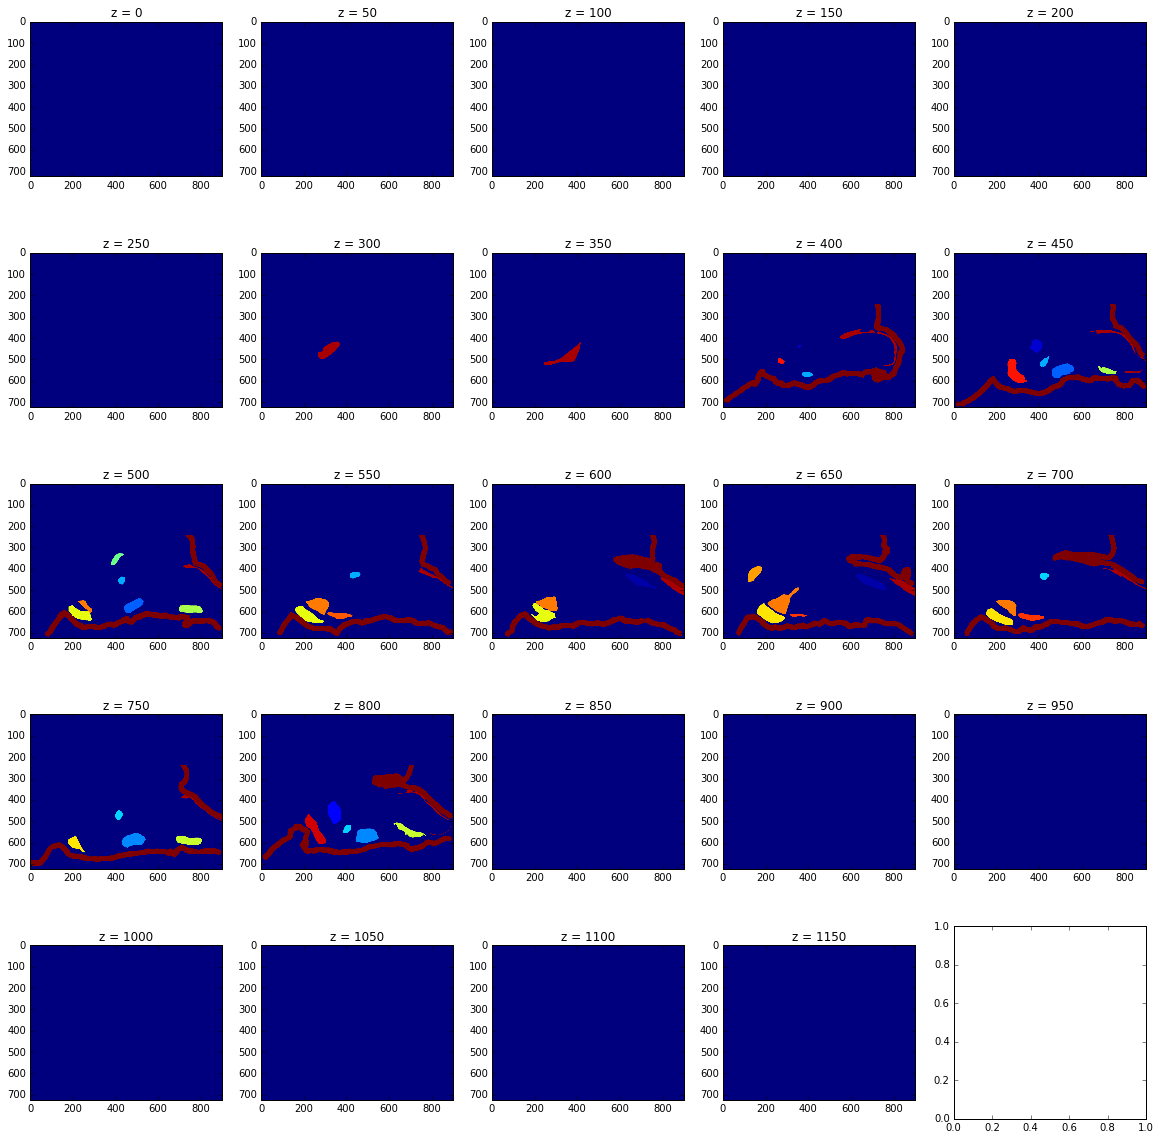

In [17]:
fig, axes = plt.subplots(5, 5, figsize=(20,20) , squeeze=True);
axes = axes.flatten()
for i, z in enumerate(range(0, volume.shape[2], 50)):
    axes[i].imshow(volume[..., z], vmin=0, vmax=len(labels_sided));
    axes[i].set_title('z = %d' % z);
plt.show();

In [ ]:
# # constant contour for between annotated sections

# dm = DataManager(stack=stack)

# volume = np.zeros((dm.image_height/downsample_factor, 
#                    dm.image_width/downsample_factor, 
#                    int(section_number_lookup[stack]*z_xy_ratio_downsampled)), np.int8)

# print volume.shape

# for sec in range(section_bs_begin, section_bs_end+1):
    
#     if sec not in label_polygons.index: continue
    
#     print sec
    
#     available_labels = label_polygons.loc[sec].dropna().index
    
#     valid_labels = set(available_labels) & set(labels)
    
#     if len(valid_labels) == 0:
#         continue
    
#     label_map = np.zeros((dm.image_height, dm.image_width), np.int8)
#     for l in valid_labels:
#         print l
        
#         t = time.time()
        
#         vs = label_polygons[l][sec]
#         xmin, ymin = np.min(vs, axis=0)
#         xmax, ymax = np.max(vs, axis=0)
                
#         if xmin > dm.image_width - 1 or ymin > dm.image_height - 1:
#             print 'min coordinates exceed image boundary'
#             continue
        
#         xmax = min(xmax, dm.image_width-1)
#         ymax = min(ymax, dm.image_height-1)
        
# #         points_to_test = np.array(list(product(range(ymin, ymax+1), range(xmin, xmax+1))))[:,::-1]
#         xs, ys = np.meshgrid(range(xmin, xmax+1), range(ymin, ymax+1))
#         points_to_test = np.c_[xs.flat, ys.flat]
        
#         print time.time() - t
        
#         is_contained = Path(vs).contains_points(points_to_test)
#         label_map[points_to_test[is_contained, 1], points_to_test[is_contained, 0]] = labels_index[l]
    
#     label_map_downsampled = label_map[::downsample_factor, ::downsample_factor]
    
#     volume[:, :, int(z_xy_ratio_downsampled*sec):int(z_xy_ratio_downsampled*(sec+1))] = label_map_downsampled[..., np.newaxis].copy()
    
#     del label_map_downsampled, label_map

In [18]:
xmin, xmax, ymin, ymax, zmin, zmax = bbox_3d(volume)

print xmin, xmax
print ymin, ymax
print zmin, zmax

reduced_xdim = xmax+1-xmin
reduced_ydim = ymax+1-ymin
reduced_zdim = zmax+1-zmin
print reduced_xdim, reduced_ydim, reduced_zdim

1 901
241 721
293 836
901 481 544


In [19]:
reduced_volume = volume[ymin:ymax+1, xmin:xmax+1, zmin:zmax+1]

In [20]:
bp.pack_ndarray_file(reduced_volume,
                     os.path.join(volume_dir, '%(stack)s/volume_%(stack)s_annotation_withOuterContour.bp' % {'stack': stack}))

In [21]:
with open(os.path.join(volume_dir, '%(stack)s/volume_%(stack)s_annotation_withOuterContour_limits.txt' % {'stack': stack}), 'w') as f:
        f.write((' '.join(['%d']*6)+'\n') % (xmin, xmax, ymin, ymax, zmin, zmax))

In [22]:
with open(os.path.join(volume_dir, '%(stack)s/volume_%(stack)s_annotation_resolution.txt' % {'stack': stack}), 'w') as f:
        f.write((' '.join(['%f']*3)+'\n') % (downsample_factor, xy_pixel_distance_downsampled, z_xy_ratio_downsampled))

In [23]:
volume1_landmark_bboxes = {name: bbox_3d(reduced_volume == labels_sided_indices[name])
                           for name in landmark_seclimits_twoSides.iterkeys()}

In [24]:
with open(volume_dir + '/%(stack)s/volume_%(stack)s_annotation_withOuterContour_landmarkBboxes.txt' % {'stack': stack}, 'w') as f:
    for name, bbox in volume1_landmark_bboxes.iteritems():
        f.write(name + ' ' + ' '.join(map(str, bbox)) + '\n')

In [25]:
with open(volume_dir + '/annotationVolume_withOuterContour_labelIndices.txt', 'w') as f:
    f.write('BackG 0\n')
    for name_s in labels_sided:
        f.write(name_s + ' ' + str(labels_sided_indices[name_s]) + '\n')